In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

%matplotlib inline

## Построение распределений и сэмплирование

In [89]:
# параметры распределений
mu0 = [-2, -2]
sigma0 = [[0.55, 0.5], [0.5, 0.55]]
mu1 = [2, 2]
sigma1 = [[0.25, 0.05], [0.05, 0.25]]


In [90]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n,1, 1))
    y1 = torch.ones((n,1, 1))
    sample = torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)
    return sample

In [91]:
d0 = torch.distributions.MultivariateNormal(loc=torch.Tensor([mu0]), covariance_matrix=torch.Tensor([sigma0]))
d1 = torch.distributions.MultivariateNormal(loc=torch.Tensor([mu1]), covariance_matrix=torch.Tensor([sigma1]))

## Обучение классификатора

In [92]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
opt = optim.SGD(lr=1e-7, params=list(layer.parameters()))

[tensor([ 0.2282,  0.1827]), tensor(1.00000e-02 *
       -6.4734)]


In [93]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000) 
            out = F.sigmoid(layer(x))           
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    x, y = sample(d0, d1, 1024)
    out = F.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    opt.step()


Ошибка после 0 итераций: 0.370786
Ошибка после 1 итераций: 0.362436
Ошибка после 2 итераций: 0.338096
Ошибка после 3 итераций: 0.302419
Ошибка после 4 итераций: 0.260194
Ошибка после 5 итераций: 0.216008
Ошибка после 6 итераций: 0.175098
Ошибка после 7 итераций: 0.138994
Ошибка после 8 итераций: 0.109136
Ошибка после 9 итераций: 0.084829
Ошибка после 10 итераций: 0.065924
Ошибка после 11 итераций: 0.051452
Ошибка после 12 итераций: 0.040537
Ошибка после 13 итераций: 0.032103
Ошибка после 14 итераций: 0.025655
Ошибка после 15 итераций: 0.020976
Ошибка после 16 итераций: 0.017202
Ошибка после 17 итераций: 0.014560
Ошибка после 18 итераций: 0.012203
Ошибка после 19 итераций: 0.010715


## Визуализация

In [94]:
def get_positions(space):
    x = np.linspace(*space)
    y = np.linspace(*space)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    return X, Y, pos

def plot_values(space, mu, sigma):
    X, Y, pos = get_positions(space)
    rv = multivariate_normal(np.array(mu), np.array(sigma))
    Z = rv.pdf(pos)    
    return X, Y, Z

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


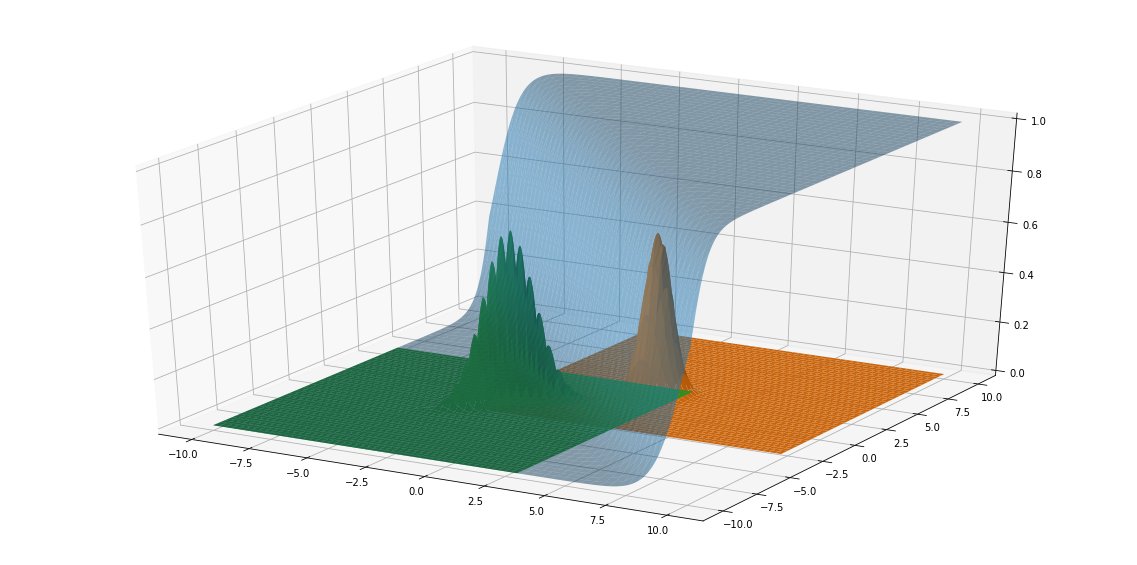

In [100]:
# Чтобы поверхности не сильно перекрывали друг друга на графике - 
# мы берем частично пересекающиеся области значений X и Y
X0, Y0, Z0 = plot_values((-10, 3, 1000), mu0, sigma0)
X1, Y1, Z1 = plot_values((-3, 10, 1000), mu1, sigma1)

X_hat, Y_hat, pos = get_positions((-10, 10, 1000))
with torch.no_grad():
    sm = torch.Tensor(pos)
    Z_hat = F.sigmoid(layer(sm)).numpy()
    Z_hat = Z_hat.reshape(1000,1000)
    
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_hat, Y_hat, Z_hat, alpha=0.5)
ax.plot_surface(X1, Y1, Z1, alpha=1)
ax.plot_surface(X0, Y0, Z0, alpha=1)
fig.show()